In [1]:
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
import math
from sklearn.metrics import accuracy_score

from utils.utils import read_label, get_label_reconstructed
from config import ExperimentConfig, get_base_path
from experiments.experiment import Experiment
from analysis.annotate_utils import read_label, get_label_reconstructed
#from config.common_path import get_ba
%matplotlib inline

/usr/local/lib/python3.7/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
pd.set_option('display.max_columns', 400)

In [3]:
N_3 = 32
N_2 = 128
N_1 = 64
Z_DIM = 5
run_id = 1

ROOT_PATH = "/Users/sunilkumar/concept_learning_old/image_classification_supervised/"
exp_config = ExperimentConfig(ROOT_PATH, 4, Z_DIM, [N_1, N_2, N_3],
                              ExperimentConfig.NUM_CLUSTERS_CONFIG_TWO_TIMES_ELBOW)
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name
exp_config.check_and_create_directories(run_id, create=False)

SPLIT_NAME = exp_config.split_name
run_ids = [1]
if not exp_config.check_and_create_directories(run_ids, create=False):
    raise Exception("Directories does not exist")

In [4]:
MODEL_NAME ="VAE"

annotator = "SUNIL"
num_label_files = 2
NUMBER_OF_ROWS = 16
NUM_DIGITS_PER_ROW = 4
MAX_BACKUPS = 10
ANNOTATED_CSV = "annotation.csv"
last_epoch = 20
eval_interval = 300

num_label_files = 2
num_rows_per_image = 16
num_digits_per_row = 4



In [5]:
def _compute_accruacy(df, step, epoch, num_label_files, labels):
    df1 = df[(df["epoch"] == epoch) & (df["step"] == step)]
    labels_batch = []
    reconstructed_batch = []
    for image_no in range(num_label_files):
        _df = df1[df1["_idx"] == image_no]
        if _df.shape[0] > 0 :
            try:
                reconstructed = get_label_reconstructed(_df[["num_rows_annotated", "text"]],
                                                        num_rows_per_image,
                                                        num_digits_per_row)
            except Exception as e:
                print("Invalid character in annotation,epoch {:01d} , step {:01d}".format(epoch,step))
                print(str(e))
                continue
                #exit()
            _reconstructed_indices = reconstructed != -2
            reconstructed_batch.extend(reconstructed[_reconstructed_indices])
            labels_batch.extend(labels[image_no][_reconstructed_indices])
    accuracy = accuracy_score(labels_batch,reconstructed_batch)
    return accuracy


In [6]:
def get_annotations(annotated_path):
    df = None
    for annotation_file in os.listdir(annotated_path):
        if annotation_file.rsplit(".",1)[1] == "csv":
            annotation_csv = os.path.join(ANNOTATED_PATH, annotation_file)
            _df = pd.read_csv(annotation_csv)
            if df is None:
                df = _df
            else:
                df = pd.concat([df,_df])
    unique = df.groupby(["epoch","step"]).size().reset_index().rename(columns={0:'count'})
    return df,unique

def compute_accuracy(labels, gt_dir, max_epoch):
    df,unique = get_annotations(gt_dir)
    unique = unique[unique["count"] > 10]
    
    epochs = []
    steps = []
    accuracies = []
    total_batches_finished = []
    for unique_combination in unique.iterrows():
        epoch = unique_combination[1]["epoch"]
        step = unique_combination[1]["step"]
        #print(epoch,step)
        accuracy = _compute_accruacy(df,step,epoch, num_label_files,labels)
        accuracies.append(accuracy)
        total_batches_finished.append(epoch * 935 + step * eval_interval )
    accuracy_df = pd.DataFrame({"Total_Batches_Finished":total_batches_finished,"Epochs":np.asarray(total_batches_finished)/935,"Accuracy":accuracies})
    accuracy_df = accuracy_df[accuracy_df["Epochs"] < max_epoch]
    return accuracy_df


In [7]:
run_id = 2
accuracy_dict =dict()
max_epoch = 5
#for z_dim in [20]:
for z_dim in [5]:
#for z_dim in [1, 2, 5, 10, 20]:
    BASE_PATH = get_base_path(ROOT_PATH, z_dim, N_3, N_2,
                              exp_config.num_cluster_config,
                              version=run_id)
    PREDICTION_RESULTS_PATH = os.path.join(BASE_PATH, "prediction_results/")
    ANNOTATED_PATH = BASE_PATH + "manual_annotation"
    
    label_file = PREDICTION_RESULTS_PATH + "/label_test_{:02d}.csv"
    labels = read_label(label_file, num_label_files)

    accuracy_df = compute_accuracy(labels, ANNOTATED_PATH, max_epoch)
    accuracy_dict[z_dim] = [max(accuracy_df["Accuracy"].values),accuracy_df]


/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


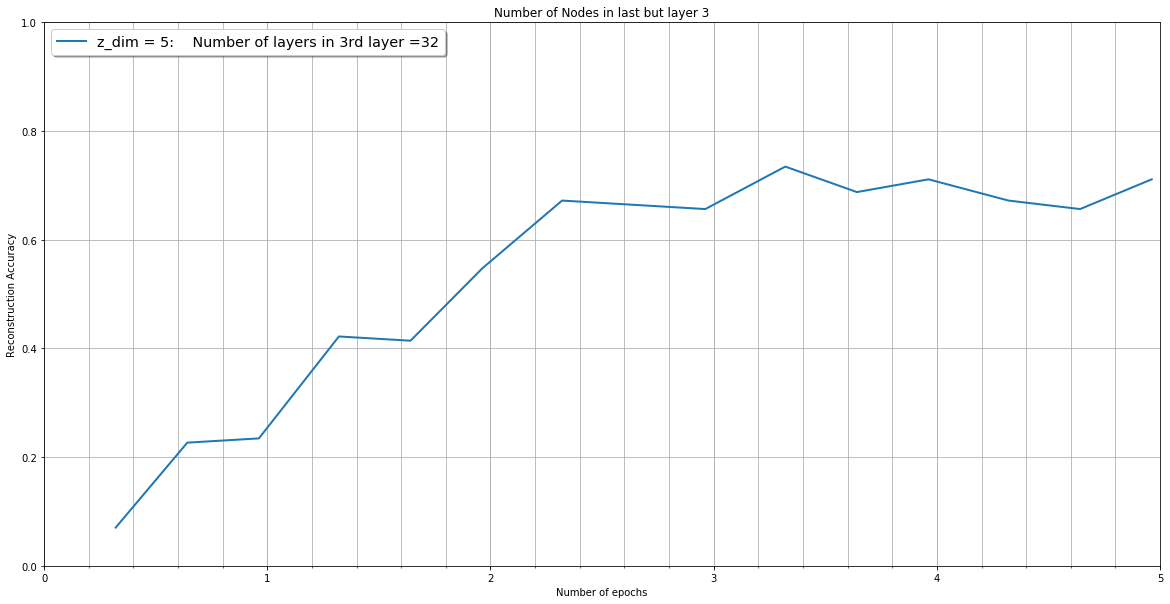

In [8]:
# TODO format the legend properly
from matplotlib.ticker import MultipleLocator
num_training_samples = 59872
steps_per_epoch = num_training_samples / BATCH_SIZE
max_steps =  max_epoch * steps_per_epoch
plt.figure(figsize=(20,10))
plot_filename = "reconstruction_accuracy.jpg"
for z_dim, result in accuracy_dict.items():
    max_accuracy = result[0]
    accuracy_df = result[1]
    x = accuracy_df["Epochs"].values
    x = x.reshape(x.shape[0])
    y = accuracy_df["Accuracy"].values
    y = y.reshape(y.shape[0])
    plt.plot(x, y, label="z_dim = {}:    Number of layers in 3rd layer ={}".format(z_dim,N_3), lw=2)
    plt.xlabel("Number of epochs")
    plt.ylabel("Reconstruction Accuracy")
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlim(0,5)
plt.ylim(0,1)
plt.grid(which="both")
plt.axes().xaxis.set_minor_locator(MultipleLocator(0.2))
plt.title("Number of Nodes in last but layer 3".format(N_3))
plt.savefig(os.path.join(ROOT_PATH, "combined_analysis", plot_filename), bbox="tight") 
#.savefig(os.path.join(DOC_PATH, plot_filename), bbox="tight")

In [9]:
for z_dim, result in accuracy_dict.items():
    print(z_dim, max(result[1]["Accuracy"].values))

5 0.734375


In [10]:
accuracy_dict =dict()
max_epoch = 5
z_dim = 5
run_ids = [2]
for run_id in run_ids:
    BASE_PATH = get_base_path(ROOT_PATH, z_dim ,N_3, N_2, exp_config.num_cluster_config, version=run_id)
    PREDICTION_RESULTS_PATH = os.path.join(BASE_PATH, "prediction_results/")
    ANNOTATED_PATH = BASE_PATH + "manual_annotation"
    label_file = PREDICTION_RESULTS_PATH + "/label_test_{:02d}.csv"
    labels = read_label(label_file, num_label_files)

    accuracy_df = compute_accuracy(labels, ANNOTATED_PATH, max_epoch)
    accuracy_dict[run_id] = [max(accuracy_df["Accuracy"].values),accuracy_df]
    

In [11]:
num_evaluations = accuracy_dict[run_ids[0]][1].shape[0]

2
reconstruction_accuracy_different_runs.jpg


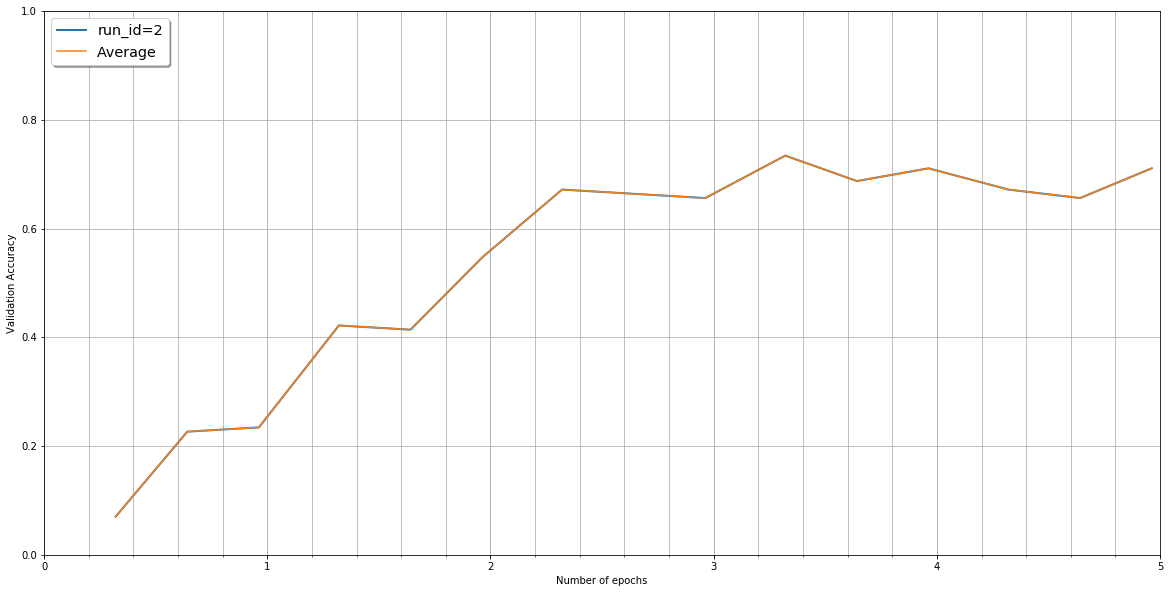

In [12]:
plt.figure(figsize=(20,10))
plot_filename = "reconstruction_accuracy_different_runs.jpg"
total = np.zeros(num_evaluations)
for run_id, result in accuracy_dict.items():
    max_accuracy = result[0]
    accuracy_df = result[1]
    x = accuracy_df["Epochs"].values
    x = x.reshape(x.shape[0])
    y = accuracy_df["Accuracy"].values
    y = y.reshape(y.shape[0])

    plt.plot(x,y,label="run_id={}".format(run_id),lw=2)
    plt.xlabel("Number of epochs")
    plt.ylabel("Validation Accuracy")
    print(run_id)
    total = total + y
average = total / len(run_ids)
plt.plot(x, average,label = "Average")

plt.legend(loc='upper left', shadow=True, fontsize='x-large')
print(plot_filename)
plt.xlim(0,max_epoch)
plt.ylim(0,1)
plt.grid(which="both")
plt.axes().xaxis.set_minor_locator(MultipleLocator(0.2))
plt.savefig(os.path.join(ROOT_PATH,"combined_analysis",plot_filename),bbox="tight") 
#plt.savefig(os.path.join(DOC_PATH,plot_filename), bbox="tight")

In [13]:
print(max(average))

0.734375


In [14]:
for run_id, result in accuracy_dict.items():
    accuracy = result[1]["Accuracy"].values
    max_index = np.argmax(accuracy)
    print(run_id, result[1]["Total_Batches_Finished"].values[max_index], 
          result[1]["Epochs"].values[max_index],
          max(accuracy), max_index)

2 3105 3.320855614973262 0.734375 9
